# Линейная регрессия
__Суммарное количество баллов: 10__


In [187]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [188]:
def read_data(path="./hw9_data/boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [189]:
def generate_synthetic(size, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Ее и нужно реализовать.

In [190]:
def mse(y_true, y_predicted):
    return np.mean((y_true - y_predicted)**2)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [191]:
class NormalLR:
    def __init__(self):
        self.w = None
    
    def fit(self, X, y):
        X_ = np.zeros((X.shape[0], X.shape[1] + 1))
        X_[:, 0] = 1
        X_[:, 1:X.shape[1] + 1] = X
        step_1 = np.matmul(X_.transpose(), y)
        step_2 = np.matmul(X_.transpose(), X_)
        step_3 = np.linalg.inv(step_2)
        self.w = np.matmul(step_3, step_1)
    
    def predict(self, X):
        X_ = np.zeros((X.shape[0], X.shape[1] + 1))
        X_[:, 0] = 1
        X_[:, 1:X.shape[1] + 1] = X
        predicted = np.dot(X_, self.w)
        return predicted

In [192]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [193]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.010317234243870557


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

### Задание 4 (2 балла)
Добавьте в метод `fit` регуляризацию Лассо с коэффициентом `l`. Постройте график зависимости ошибки предсказания данных из синтетического набора данных от коэффициента регуляризации.

In [194]:
class L1Regularization:
    def __init__(self, l):
        self.l = l
    
    def __call__(self, w):
        return self.l * np.linalg.norm(w)
    
    def grad(self, w):
        return self.l * np.sign(w)

class GradientLR:
    def __init__(self, alpha, iterations=10000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.w = None
        self.regularization = L1Regularization(l=self.l)
    
    def fit(self, X, y):
        X_ = np.zeros((X.shape[0], X.shape[1] + 1))
        X_[:, 0] = 1
        X_[:, 1:X.shape[1] + 1] = X
        limit = 1 / np.sqrt(X_.shape[1])
        self.w = np.random.uniform(-limit, limit, (X_.shape[1], ))
        for _ in range(self.iterations):
            y_pred = X_.dot(self.w)
            D = -(y - y_pred).dot(X_) + self.regularization.grad(self.w)
            self.w = self.w - self.alpha * D 

    def predict(self, X):
        X_ = np.zeros((X.shape[0], X.shape[1] + 1))
        X_[:, 0] = 1
        X_[:, 1:X.shape[1] + 1] = X
        predicted = np.dot(X_, self.w)
        return predicted

In [195]:
def build_plot(X_train, y_train, X_test, y_test):
    mses = []
    ls = np.linspace(0.005, 0.15)
    for l in ls:
        regr = GradientLR(alpha=0.01, iterations=100, l=l)
        regr.fit(X_train, y_train)
        mses.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(12, 8))
    plt.plot(ls, mses)
    plt.xlabel('Parameter l')
    plt.ylabel('MSE')
    plt.show()

In [196]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

4.710950956761335e+187


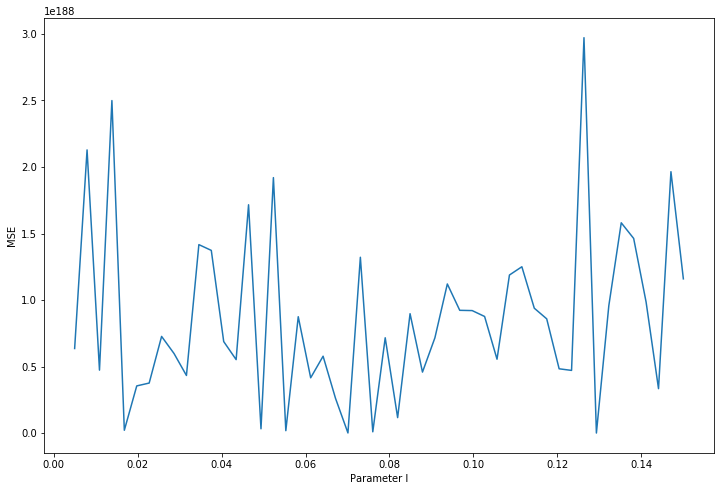

In [197]:
regr = GradientLR(alpha=0.01, iterations=100, l=0.1)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test)

### Задание 5 (2 балла)
Протесируйте оба метода на данных cancer и spam, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

Датасет cancer:

In [198]:
data = pd.read_csv('./hw9_data/cancer.csv')
X = data.drop('label', axis=1).values
y = data['label'].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [199]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.05986875983373604


In [200]:
def build_plot(X_train, y_train, X_test, y_test):
    mses = []
    ls = np.linspace(0.005, 0.15)
    for l in ls:
        regr = GradientLR(alpha=0.01, iterations=10, l=l)
        regr.fit(X_train, y_train)
        mses.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(12, 8))
    plt.plot(ls, mses)
    plt.xlabel('Parameter l')
    plt.ylabel('MSE')
    plt.show()

2.0119988471600275e+142


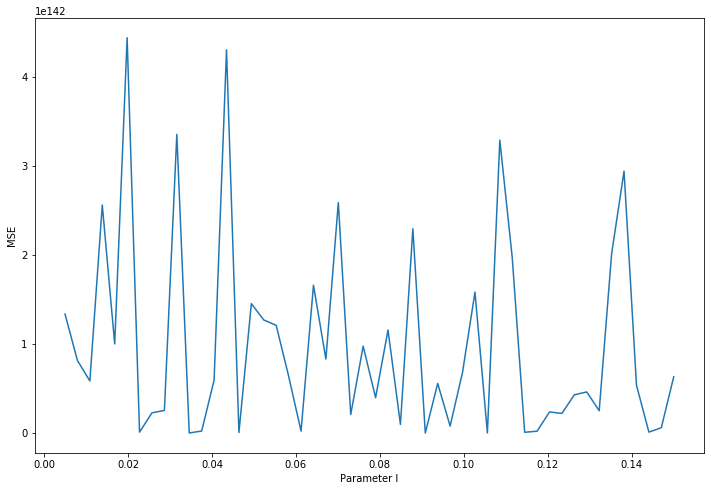

In [201]:
regr = GradientLR(alpha=0.01, iterations=10, l=0.005)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test)

Датасет spam:

In [202]:
data = pd.read_csv('./hw9_data/spam.csv')
X = data.drop('label', axis=1).values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [203]:
def build_plot(X_train, y_train, X_test, y_test):
    mses = []
    ls = np.linspace(0.005, 0.15)
    for l in ls:
        regr = GradientLR(alpha=0.01, iterations=10, l=l)
        regr.fit(X_train, y_train)
        mses.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(12, 8))
    plt.plot(ls, mses)
    plt.xlabel('Parameter l')
    plt.ylabel('MSE')
    plt.show()

2.2745205761327276e+149


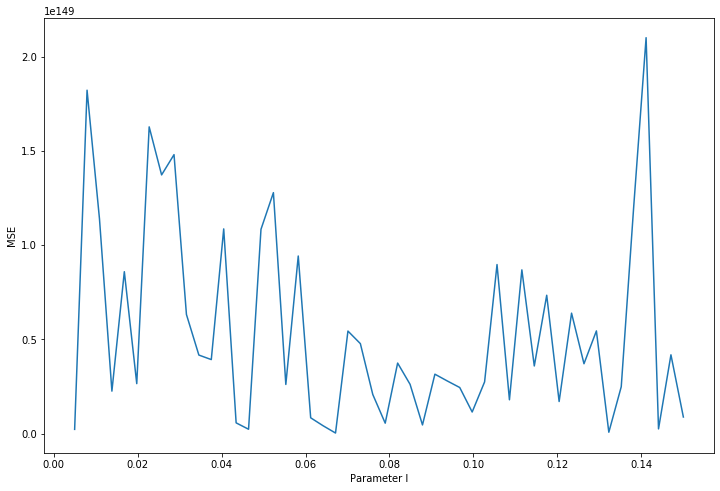

In [204]:
regr = GradientLR(alpha=0.01, iterations=10, l=0.005)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test)